In [1]:
import time
print("Current time is:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

Current time is: 2025-06-04 21:34:03


In [2]:
# === Top level imports ===
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader, DistributedSampler
from torch.optim.lr_scheduler import ExponentialLR

import matplotlib.pyplot as plt

import xarray as xr
import zarr
import numpy as np
from scipy.spatial import cKDTree
from scipy.interpolate import griddata
import pandas as pd
import time

import os
import wandb, argparse, sys
from tqdm import tqdm

from data_loader import nowcast_dataset, Transform
from models.Google_Unet import GoogleUNet
from models.Deep_CNN import DCNN
from models.UNet import UNet
from models.SwinT2_UNet import SwinT2UNet
from models.util import initialize_weights_xavier,initialize_weights_he

from losses import MaskedMSELoss, MaskedRMSELoss, MaskedTVLoss, MaskedCharbonnierLoss, MaskedCombinedMAEQuantileLoss

from util import str_or_none, int_or_none, bool_from_str, EarlyStopping, save_model_checkpoint, restore_model_checkpoint, init_zarr_store

/home/harish/miniconda3/envs/gUstNET/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
variable = 'i10fg'  # Input variable to predict
checkpoint_dir = 'checkpoints'
model_name = 'UNet'
activation_layer = 'gelu'
transform = 'standard'  # 'standard' or 'minmax'
batch_size = 16
num_workers = 16
weights_seed = 42
num_epochs = 200
loss_name = 'MaskedCharbonnierLoss'
resume = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# === Loading some topography and masking data ===
orography = xr.open_dataset('orography.nc')
RTMA_lat = orography.latitude.values    # Nx, Ny 2D arrays
RTMA_lon = orography.longitude.values   # Nx, Ny 2D arrays
orography = orography.orog.values

mask = xr.open_dataset('mask_2d.nc').mask
mask_tensor = torch.tensor(mask.values, device=device)  # [H, W], defnitely send it to device

# %%
zarr_store = 'data/NYSM.zarr'
train_val_dates_range = ['2019-01-01T00:00:00', '2019-12-31T23:59:59']
test_dates_range = ['2023-01-01T00:00:00', '2023-12-31T23:59:59']
freq = '5min'
input_window_size = 2  # 3 hours at every 5 minutes
output_window_size = 1  # 1 hour at every 5 minutes
data_seed = 42

NYSM_stats = xr.open_dataset('NYSM_variable_stats.nc')
input_stats = NYSM_stats.sel(variable=[variable])
target_stats = NYSM_stats.sel(variable=[variable])
# Standardization
input_transform = Transform(
    mode=transform,  # 'standard' or 'minmax'
    stats=input_stats
)
target_transform = Transform(
    mode=transform,  # 'standard' or 'minmax'
    stats=target_stats
)

mode = 'test'
test_dataset = nowcast_dataset(
    zarr_store,
    variable,
    test_dates_range,
    input_window_size,
    output_window_size,
    freq,
    missing_times=None,
    mode=mode,
    data_seed=data_seed
    )

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    sampler=None,
    shuffle=None, # shuffle if not using DDP
    pin_memory=True,prefetch_factor=4, persistent_workers=True,
    num_workers=num_workers,
    drop_last=True
)
print("Data loaded successfully.")
print(f"Test dataset size: {len(test_dataset)}")

Data loaded successfully.
Test dataset size: 105118


In [5]:
# === Set up device, model, loss, optimizer ===
input_resolution = (orography.shape[0], orography.shape[1])
in_channels = input_window_size
out_channels = output_window_size

if activation_layer == 'gelu':
    act_layer = nn.GELU
elif activation_layer == 'relu':
    act_layer = nn.ReLU
elif activation_layer == 'leakyrelu':
    act_layer = nn.LeakyReLU

if model_name == "DCNN":
    C = 48
    kernel = (7, 7)
    final_kernel = (3, 3)
    n_layers = 7
    model = DCNN(in_channels=in_channels, 
                    out_channels=out_channels, 
                    C=C, 
                    kernel=kernel,
                    final_kernel=final_kernel, 
                    n_layers=n_layers,
                    act_layer=act_layer,
                    hard_enforce_stations=True).to(device)
elif model_name == "UNet":
    C = 32
    n_layers = 4
    dropout_prob=0.2
    drop_path_prob=0.2
    model = UNet(in_channels=in_channels, 
                    out_channels=out_channels,
                    C=C, 
                    dropout_prob=dropout_prob,
                    drop_path_prob=drop_path_prob,
                    act_layer=act_layer,
                    n_layers=n_layers,
                    hard_enforce_stations=True).to(device)

elif model_name == "SwinT2UNet":
    C = 32
    n_layers = 4
    window_sizes = [8, 8, 4, 4, 2]
    head_dim = 32
    attn_drop = 0.2
    proj_drop = 0.2
    mlp_ratio = 4.0
    model = SwinT2UNet(input_resolution=input_resolution, 
                    in_channels=in_channels, 
                    out_channels=out_channels, 
                    C=C, n_layers=n_layers, 
                    window_sizes=window_sizes,
                        head_dim=head_dim,
                        attn_drop=attn_drop,
                        proj_drop=proj_drop,
                        mlp_ratio=mlp_ratio,
                        act_layer=act_layer,
                        hard_enforce_stations=True).to(device)

if act_layer == nn.GELU:
        initialize_weights_xavier(model,seed = weights_seed)
elif act_layer == nn.ReLU:
    initialize_weights_he(model,seed = weights_seed)
elif act_layer == nn.LeakyReLU:
    initialize_weights_he(model,seed = weights_seed)

# Define the loss criterion and metric here, based on input loss name. The functions are sent to the GPU inside
if loss_name == "MaskedMSELoss":
    criterion = MaskedMSELoss(mask_tensor)
elif loss_name == "MaskedRMSELoss":
    criterion = MaskedRMSELoss(mask_tensor)
elif loss_name == "MaskedTVLoss":
    criterion = MaskedTVLoss(mask_tensor,tv_loss_weight=0.001, beta=0.5)    
elif loss_name == "MaskedCharbonnierLoss":
    criterion = MaskedCharbonnierLoss(mask_tensor,eps=1e-3)
metric = MaskedRMSELoss(mask_tensor)

# === Optimizer, scheduler, and early stopping ===
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.9)
early_stopping = EarlyStopping(patience=120, min_delta=0.0)
if not dist.is_initialized() or dist.get_rank() == 0:
    print("Model created and moved to device.")

Model created and moved to device.


In [6]:
latest_ckpt_path = os.path.join(checkpoint_dir, "latest.pt")
model, optimizer, scheduler, start_epoch = restore_model_checkpoint(model, optimizer, scheduler, latest_ckpt_path, device)

Restored checkpoint from: checkpoints/latest.pt (epoch 130)


In [7]:
metric_2 = MaskedCombinedMAEQuantileLoss(mask_tensor)

In [8]:
iterator = iter(test_dataloader)
with torch.no_grad():
    # Example usage
    for b in range(1):
        start_time = time.time()
        batch = next(iterator, None)

        if batch is not None:
            input_tensor, target_tensor, input_time_instances, target_time_instances = batch
            input_tensor = input_tensor.to(device, non_blocking=True)
            target_tensor = target_tensor.to(device, non_blocking=True)

            # Transform input and target
            if input_transform is not None:
                input_tensor = input_transform(input_tensor)
                target_tensor = target_transform(target_tensor)
                
            output = model(torch.where(mask_tensor, input_tensor, 0))  # shape: [13, 1, H, W] if batch size = 13
            print(criterion(torch.where(mask_tensor, output, 0), torch.where(mask_tensor, target_tensor, 0)))   # Not transformed
            print(metric(torch.where(mask_tensor, output, 0), torch.where(mask_tensor, target_tensor, 0)))  # Not transformed
            print(metric_2(torch.where(mask_tensor, output, 0), torch.where(mask_tensor, target_tensor, 0)))  # Not transformed
            
            if target_transform is not None:
                output = target_transform.inverse(output)
                target_tensor = target_transform.inverse(target_tensor)
            print(criterion(torch.where(mask_tensor, output, 0), torch.where(mask_tensor, target_tensor, 0)))   # transformed, so m/s
            print(metric(torch.where(mask_tensor, output, 0), torch.where(mask_tensor, target_tensor, 0)))  # Trnasformed, so m/s
            print(metric_2(torch.where(mask_tensor, output, 0), torch.where(mask_tensor, target_tensor, 0)))  # Trnasformed, so m/s

tensor(0.1554, device='cuda:0')
tensor(0.2183, device='cuda:0')
tensor(0.1206, device='cuda:0')
tensor(0.4003, device='cuda:0')
tensor(0.5623, device='cuda:0')
tensor(0.3105, device='cuda:0')


In [64]:
output_ds = xr.Dataset(
        {
            variable: (['time', 'y', 'x'], output.squeeze(1).cpu().numpy())
        },
        coords={
        'time': np.array(target_time_instances, dtype='datetime64[ns]'),
        'latitude': (('y', 'x'), RTMA_lat),
        'longitude': (('y', 'x'), RTMA_lon)
        }
    )
target_ds = xr.Dataset(
        {
            variable: (['time', 'y', 'x'], target_tensor.squeeze(1).cpu().numpy())
        },
        coords={
        'time': np.array(target_time_instances, dtype='datetime64[ns]'),
        'latitude': (('y', 'x'), RTMA_lat),
        'longitude': (('y', 'x'), RTMA_lon)
        }
    )

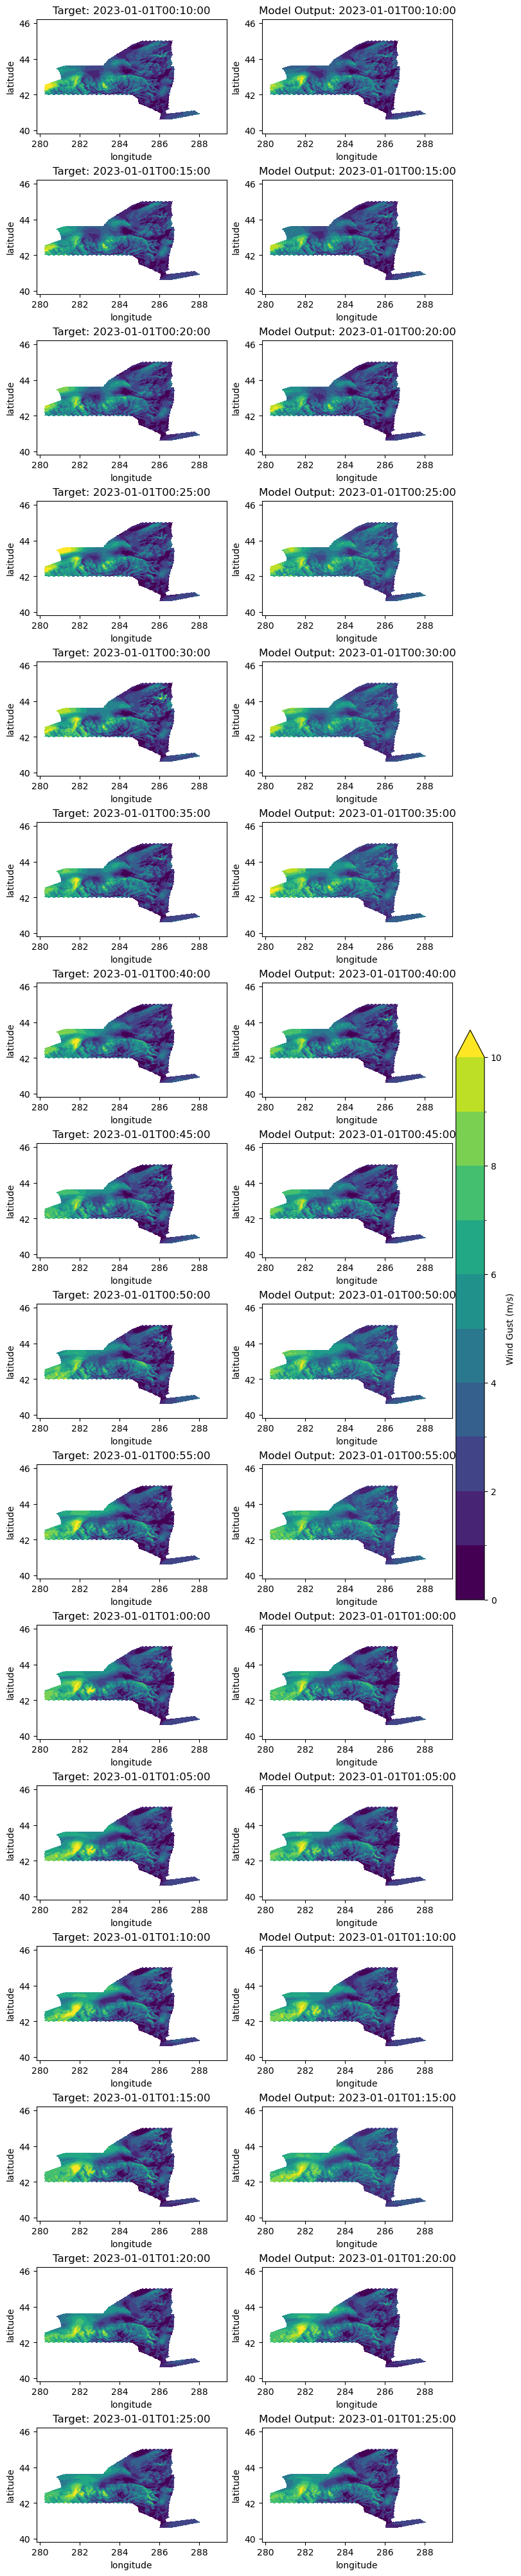

In [65]:
fig, axes = plt.subplots(output_ds.sizes['time'], 2, figsize=(8, 40), constrained_layout=True)

levels = np.arange(0,10.1,1)  # Adjust levels as needed
for i in range(output_ds.sizes['time']):
    # Plot output
    ax = axes[i,0]
    im0 = target_ds.i10fg.isel(time=i).where(mask).plot(ax=ax, x='longitude', y='latitude', cmap='viridis', levels=levels, vmin=levels[0], vmax=levels[-1], add_colorbar=False)
    ax.set_title(f"Target: {target_ds.time.values[i].astype('datetime64[s]')}")

    # Plot target
    ax = axes[i,1]
    im1 = output_ds.i10fg.isel(time=i).where(mask).plot(ax=ax, x='longitude', y='latitude', cmap='viridis', levels=levels, vmin=levels[0], vmax=levels[-1], add_colorbar=False)
    ax.set_title(f"Model Output: {output_ds.time.values[i].astype('datetime64[s]')}")

# Add common colorbar
cbar = fig.colorbar(im1, ax=axes[:,1], orientation='vertical', shrink=0.8, pad=0.02)
cbar.set_label("Wind Gust (m/s)")